# Posterior evaluation and analysis

Once we have obtained a posterior estimate using SBI (see `2_inference`), it is important to evaluate the accuracy and reliability of this estimate before we can analyze it. 
The `sbi` package provides methods to do this: 

- we can sample parameter values from the posterior and compare the resulting simulated data with the real data to check the predicitive accuracy of the posterior
- we can run simulation-based calibration (Talts et al. 2018) to check whether the posterior variances are well-calibrated (see main paper and Talts et al. 2018 for details)
- we can analyze the posterior correlations to detect parameter interactions

In [6]:
import pickle
import torch
import matplotlib.pyplot as plt

from sbi.analysis import pairplot
from sbi.inference import SNPE
from sbi.utils import posterior_nn
from sbi.analysis import run_sbc, sbc_rank_plot
from sbi.inference import prepare_for_sbi, simulate_for_sbi

from consbi import DATA_PATH, RESULTS_PATH, BASE_PATH
from consbi.simulators import RuleSimulator
from consbi.simulators import default_rule

plt.style.use(str(BASE_PATH.joinpath("figures/plotting_settings.mplstyle")))
%matplotlib inline

### Load inference results

In [83]:
# load inference results
with open(RESULTS_PATH.joinpath(f"npe_dso_gaussian_05_n500000r2x100k.p"), "rb") as fh: 
    prior, de, posteriors, thos, xos, kwargs, seed = pickle.load(fh).values()
    
# we loaded inference results from the paper for better demonstration. 
posterior = posteriors[0]  # contains posteriors for multiple rounds, we select the one from the first round.

## Posterior predictive checks

To simulate data we need to set up the simulator first.

In [7]:
# the structural features of the model are saved to disk. specify the path:
path_to_model = str(BASE_PATH.joinpath("data/structural_model"))

# set number of neuron pairs sampled from the connectome to mimick experimental settings, e.g., 50
num_subsampling_pairs = 50

# set the default rule as wiring rule (DSO)
simulator = RuleSimulator(path_to_model, 
                          default_rule, 
                          verbose=True, 
                          num_subsampling_pairs=num_subsampling_pairs)

Loading features, this may take a while...
Time elapsed: 157.06517148017883


/home/janfb/qode/sbi-for-connectomics/consbi/simulators/rule_simulator.py:657: RuntimeWarning: invalid value encountered in log
  log_features = np.log(features)


constraint 0, num rows (with overlap) 2168393
constraint 1, num rows (with overlap) 687074
constraint 2, num rows (with overlap) 308345
constraint 3, num rows (with overlap) 674175
constraint 4, num rows (with overlap) 559727
constraint 5, num rows (with overlap) 587659
constraint 6, num rows (with overlap) 1096435


In [84]:
num_simulations = 1000
num_workers = 20  # number of CPUs
xo = torch.tensor([[0.4300, 0.4300, 0.4200, 0.6400, 0.1700, 0.4400, 0.0900]])

posterior.set_default_x(xo)

# wrap the simulator to handle batches of parameters
batch_simulator, prior = prepare_for_sbi(simulator, prior)

# we simulate with parameters sampled from the posterio.
thos, xos = simulate_for_sbi(batch_simulator, posterior, num_simulations=num_simulations, 
                            num_workers=num_workers, 
                            simulation_batch_size=10)

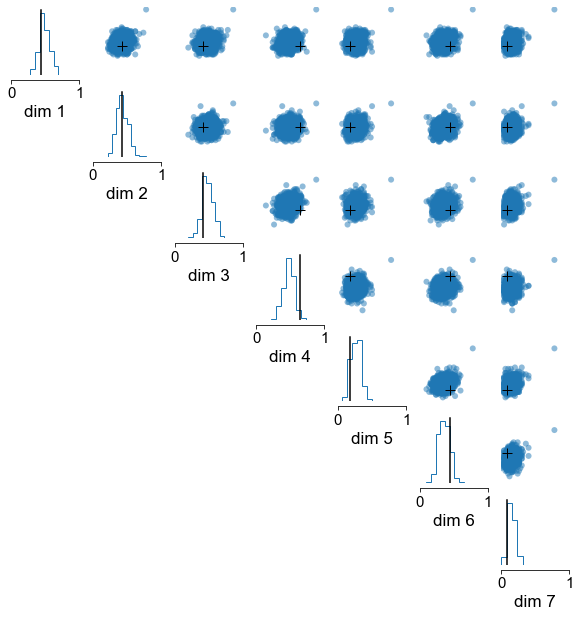

In [85]:
# we visualize the posterior predictive distribution using a pairplot:
pairplot(x_pred.squeeze(), 
         upper="scatter", 
         points=xo,
         points_offdiag=dict(marker="+", markersize=10),
         hist_diag=dict(bins=10),
         points_colors=["k"],
         limits=[[0, 1]]*7,
        );

### Result:
The posterior predictive samples contain the observed data; that's a good sign. We continue with the calibration analysis using SBC. 

## Simulation-based calibration (SBC)

To perform SBC we repeat the inference many times using different (simulated) data points and check where the underlying parameters are located in the inferred posterior, i.e., we calculate their rank under the posterior.

If the variances of the posterior are well-calibrated then these ranks must be uniformly distributed. I.e., if the ranks are not uniform there is something off! 

We can use the SBI package to perform SBC. 
To run SBC we need simulated data. Above we loaded this data from disk. In practice, one has to simulated extra data with parameters sampled from the prior. It must not be the same data as used during training but unseen data.

In [86]:
num_sbc_points = 1000
num_posterior_samples = 1000

# we simulate with parameters sampled from the prior.
thos, xos = simulate_for_sbi(batch_simulator, prior, num_simulations=num_sbc_points, 
                            num_workers=num_workers, 
                            simulation_batch_size=10)


# run SBC using sbi package
ranks, dap_samples = run_sbc(thos[:num_sbc_points], 
                             xos[:num_sbc_points], 
                             posterior, 
                             num_posterior_samples=num_posterior_samples, 
                             show_progress_bar=True
                            )

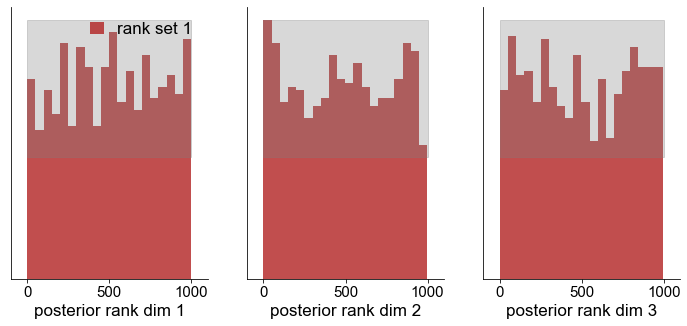

In [87]:
# we can visualize the resulting ranks to check for uniformity:
fig, ax = sbc_rank_plot(ranks, num_posterior_samples, plot_type="hist", num_bins=20)

### Result: 
The ranks appear uniformly distributed, therefore, the posterior is well-calibrated.

## Posterior analysis with posterior correlations

We can look for potential interactions between model parameters by

- visual inspection of the posterior pairplot
- calculating the correlation between parameter values sampled from the posterior
- calculating conditional correlations

### Visual inspection

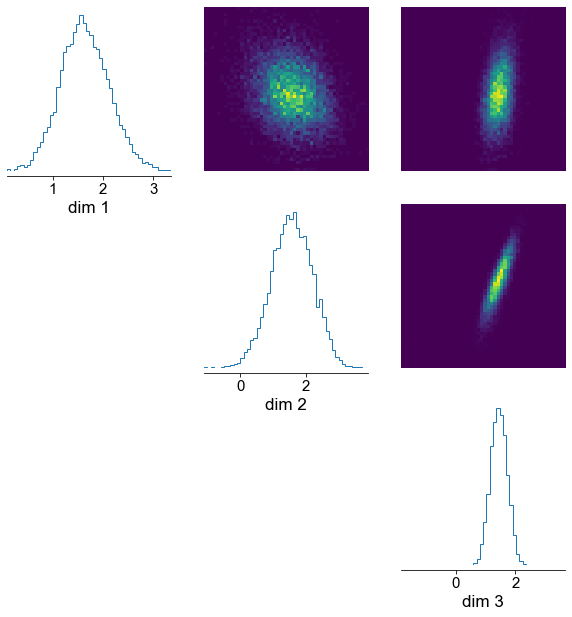

In [89]:
posterior_samples = posterior.sample((10000,))
pairplot(posterior_samples);

You can recognize a potential correlation by looking for elongated shapes in the 2-D posterior marginals. 

The posterior 1-D marginals are relatively broad, similar to the prior. However, in the 2-D marginals we see strong signs of correlations, indicating parameter interactions. 

We can quantify these correlations by calucalting the Pearson correlation coefficients between posterior samples: 

In [90]:
import numpy as np

np.corrcoef(posterior_samples, rowvar=False)

array([[ 1.        , -0.24534447,  0.2921147 ],
       [-0.24534447,  1.        ,  0.83729535],
       [ 0.2921147 ,  0.83729535,  1.        ]])

The correlation matrix confirms the strong correlations between all three parameters, a negative correlation between `dim 1` and `dim 2` and a positive correlation between `dim 2` and `dim 3`. 

In other scenarios, the correlation might not be visible as obviously as here. 
For example, in a high-dimensional posterior, correlations might not be visible in the 2-D marginals shown in the pairplot. In that case we might be able to still seem them when calculating conditional correlations, e.g., by calculating the correlations between posterior samples that were sampled by conditioning on other parameter values. See the corresponding tuturial in the `sbi` package for details: 
https://github.com/mackelab/sbi/blob/main/tutorials/07_conditional_distributions.ipynb

## The end

This ends the workflow for applying SBI to wiring rules in the barrel cortex. 

The workflow of `simulation`, `inference`, and `analysis` can be applied to any other computational connectomics model as well. All you need is

- a model with free parameters that can simulate data given parameter
- corresponding observed data
- a prior distribution over the free parameters, e.g., a uniform prior in the ranges of parameters values you find plausible

Just install the `sbi` package from https://github.com/mackelab/sbi and follow these three tutorials to set up your own workflow. 

Do not hesitate to create an issue in this or in the https://github.com/mackelab/sbi repository.